<a href="https://colab.research.google.com/github/alme9155/csca-5522/blob/main/Colab_NFL_Data_Mining_Project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCA-5522: Data Mining Project #
#### A Data Mining Exploration with NFL Big Data Bowl Datasets. ####
    
* Author: Alexander Meau  
* Email: alme9155@colorado.edu  
* GitHub: [https://github.com/alme9155/csca-5522/tree/main](https://github.com/alme9155/csca-5522/tree/main)  

In [1]:
import numpy as np
import pandas as pd
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the data directory in Google Drive
data_dir = '/content/drive/MyDrive/nfl_data'

# List all files in the data directory to verify
print("Files in data directory:")
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Mounted at /content/drive
Files in data directory:
/content/drive/MyDrive/nfl_data/games.csv
/content/drive/MyDrive/nfl_data/player_play.csv
/content/drive/MyDrive/nfl_data/plays.csv
/content/drive/MyDrive/nfl_data/players.csv
/content/drive/MyDrive/nfl_data/tracking_week_1.csv
/content/drive/MyDrive/nfl_data/tracking_week_2.csv
/content/drive/MyDrive/nfl_data/tracking_week_3.csv
/content/drive/MyDrive/nfl_data/tracking_week_4.csv
/content/drive/MyDrive/nfl_data/tracking_week_5.csv
/content/drive/MyDrive/nfl_data/tracking_week_6.csv
/content/drive/MyDrive/nfl_data/tracking_week_7.csv
/content/drive/MyDrive/nfl_data/tracking_week_8.csv
/content/drive/MyDrive/nfl_data/tracking_week_9.csv


## I. Brief description of the problem and data ##

This data mining project aims to predict post-snap play outcomes (e.g., pass completion, yards gained, or tackle success) in NFL pre-season games using Graph Neural network. My project focus is to analyze pre-snap positioning and dynamic attributes of both offensive and defensive players (e.g., quarterback, wide receivers, running backs) to predict post-snap play success.

This work will leverage the NFL Big Data Bowl 2025 dataset, which includes pre-snap statistics of player position, acceleration of every game play, and their corresponding post-snap outcome.

### Dataset: ####
* Dataset include 4 categories of data:
  * **players.csv**: Contains player metadata, including IDs, names, positions, and player physical attributes.
  * **plays.csv**: Describes play-level information, such as game context, play  type, and outcomes.
  * **player_play.csv**: Links players to specific plays, detailing their involvement and roles in each play.
  * **tracking_week_x.csv**: Provides frame-by-frame player tracking data, capturing positions, speeds, and orientations for each week.
  
### Data Size and Dimension ####
* **players.csv**: ~2,000 player records
* **plays.csv**: ~10,000-20,000 play records and outcomes.
* **player_play.csv**: ~100,000 records linking players to specific plays.
* **tracking_week_x.csv**: ~10-100 million rows across weeks 1-9, capturing player coordinates, speed, and orientation at 10 Hz.


## II. Exploratory Data Analysis (EDA) ##
- Examine video quality:
  - Dimension (width x height)
  - Frame Count and Frame per secound
  - Total count of video clips
  - Total count of video category

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, glob, math
from scipy.spatial import distance_matrix

In [4]:
# file path
# data_dir = "/kaggle/input/nfl-big-data-bowl-2025-archived-data/"
players_file = f"{data_dir}/players.csv"
plays_file = f"{data_dir}/plays.csv"
player_play_file = f"{data_dir}/player_play.csv"
games_file = f"{data_dir}/games.csv"
tracking_files = [f"{data_dir}/tracking_week_{i}.csv" for i in range(1, 10)]

# df
players_df = pd.read_csv(players_file)
plays_df = pd.read_csv(plays_file)
player_play_df = pd.read_csv(player_play_file)
games_df  = pd.read_csv(games_file)

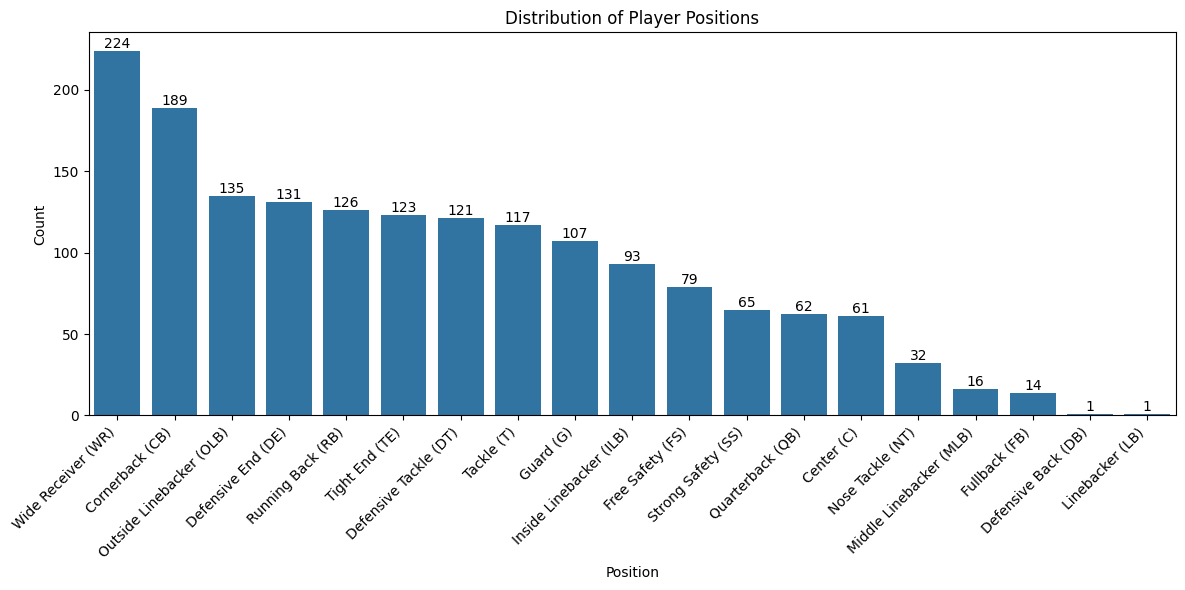

In [6]:
position_translation = {
    'WR': 'Wide Receiver (WR)', 'CB': 'Cornerback (CB)', 'OLB': 'Outside Linebacker (OLB)',
    'DE': 'Defensive End (DE)', 'RB': 'Running Back (RB)', 'TE': 'Tight End (TE)',
    'DT': 'Defensive Tackle (DT)', 'T': 'Tackle (T)', 'G': 'Guard (G)',
    'ILB': 'Inside Linebacker (ILB)', 'FS': 'Free Safety (FS)', 'SS': 'Strong Safety (SS)',
    'QB': 'Quarterback (QB)', 'C': 'Center (C)', 'NT': 'Nose Tackle (NT)',
    'MLB': 'Middle Linebacker (MLB)', 'FB': 'Fullback (FB)', 'DB': 'Defensive Back (DB)',
    'LB': 'Linebacker (LB)', 'K': 'Kicker (K)', 'P': 'Punter (P)', 'LS': 'Long Snapper (LS)',
}


position_counts = players_df['position'].value_counts()
position_counts_df = position_counts.reset_index()
position_counts_df.columns = ['Position', 'Count']
position_counts_df['Position_Full'] = position_counts_df['Position'].map(position_translation)

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=position_counts_df, x='Position_Full', y='Count')
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=10)
plt.title("Distribution of Player Positions")
plt.xlabel("Position")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [40]:
# Label prep
plays_df = plays_df.copy()
plays_df["passResultNorm"] = plays_df["passResult"].astype("string").str.strip().str.upper()

is_pass        = plays_df["passResultNorm"].isin(["C","I","S","IN"])
is_completed   = plays_df["passResultNorm"].eq("C")
yg             = plays_df["yardsGained"].fillna(0)

plays_df["isPassPlay"]            = is_pass
plays_df["isCompleted"]           = is_completed
plays_df["isWinningPass"]         = is_completed & (yg > 0)      # completed + positive yards
plays_df["isCompletedZeroGain"]   = is_completed & (yg == 0)     # completed + exactly 0 yards
plays_df["isCompletedNoGain"]     = is_completed & (yg <= 0)     # completed + zero OR negative
plays_df["isCompletedNegGain"]    = is_completed & (yg < 0)      # completed + negative yards

print("Winning passes:", int(plays_df["isWinningPass"].sum()))
print("Completed zero-gain:", int(plays_df["isCompletedZeroGain"].sum()))


Winning passes: 5347
Completed zero-gain: 94



Loading plays.csv...
Plays Data Row Count: 16124

Pass Result Distribution:
  Pass_Result  Count           Pass_Result_Full
0         NaN   6388     Non-Pass/Unknown (NaN)
1           C   5624         Completed Pass (C)
2           I   2911        Incomplete Pass (I)
3           S    608                 Sacked (S)
4           R    400  Interception Returned (R)
5          IN    193          Interception (IN)


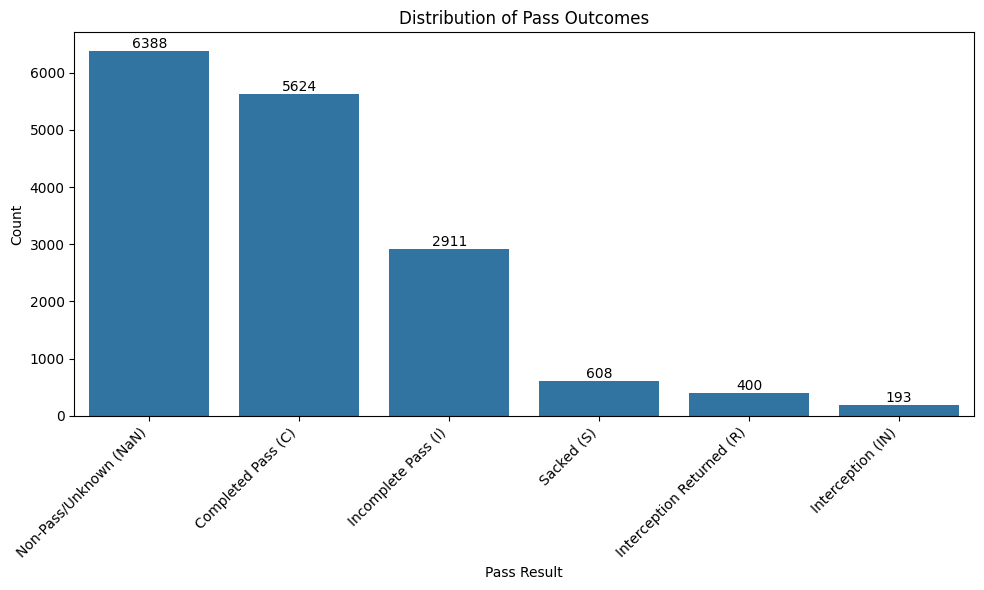

In [7]:
print("\nLoading plays.csv...")
pass_result_translation = {
    'NaN': 'Non-Pass/Unknown (NaN)',
    'C': 'Completed Pass (C)',
    'I': 'Incomplete Pass (I)',
    'S': 'Sacked (S)',
    'R': 'Interception Returned (R)',
    'IN': 'Interception (IN)'
}
plays_row_count = len(plays_df)
print(f"Plays Data Row Count: {plays_row_count}")

# Compute pass result distribution dynamically
pass_result_counts = plays_df['passResult'].value_counts(dropna=False).reset_index()
pass_result_counts.columns = ['Pass_Result', 'Count']
pass_result_counts['Pass_Result'] = pass_result_counts['Pass_Result'].fillna('NaN').astype(str)
pass_result_counts['Pass_Result_Full'] = pass_result_counts['Pass_Result'].map(pass_result_translation)
print("\nPass Result Distribution:")
print(pass_result_counts[['Pass_Result', 'Count', 'Pass_Result_Full']])

# Visualize pass result distribution with counts
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=pass_result_counts, x='Pass_Result_Full', y='Count')
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=10)
plt.title("Distribution of Pass Outcomes")
plt.xlabel("Pass Result")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Player-Play Data Row Count: 354727

Offensive vs Defensive Players:
is_offensive
Defense    298932
Offense     55795
Name: count, dtype: int64


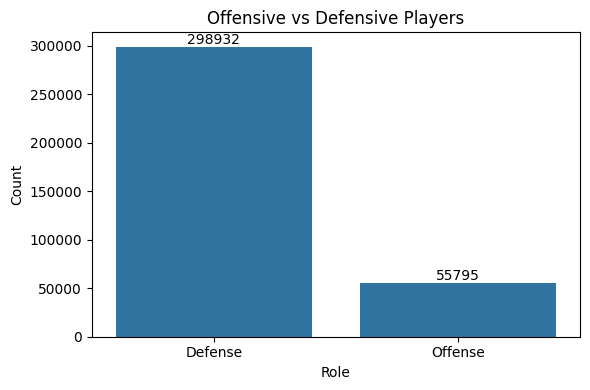

In [8]:
player_play_row_count = len(player_play_df)
print(f"Player-Play Data Row Count: {player_play_row_count}")
# print("Player-Play Data Info:")
#print(player_play_df.info())

# Infer offensive players using relevant columns
offensive_cols = ['hadRushAttempt', 'hadDropback', 'hadPassReception', 'wasTargettedReceiver', 'wasRunningRoute']
player_play_df['is_offensive'] = player_play_df[offensive_cols].any(axis=1).astype(int)
offense_defense_counts = player_play_df['is_offensive'].value_counts().rename({1: 'Offense', 0: 'Defense'})
print("\nOffensive vs Defensive Players:")
print(offense_defense_counts)

# Visualize offense vs defense distribution with counts
plt.figure(figsize=(6, 4))
bar_plot = sns.barplot(x=offense_defense_counts.index, y=offense_defense_counts.values)
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=10)
plt.title("Offensive vs Defensive Players")
plt.xlabel("Role")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Processing /content/drive/MyDrive/nfl_data/tracking_week_1.csv...
Tracking Data Row Count (Week 1): 7104700


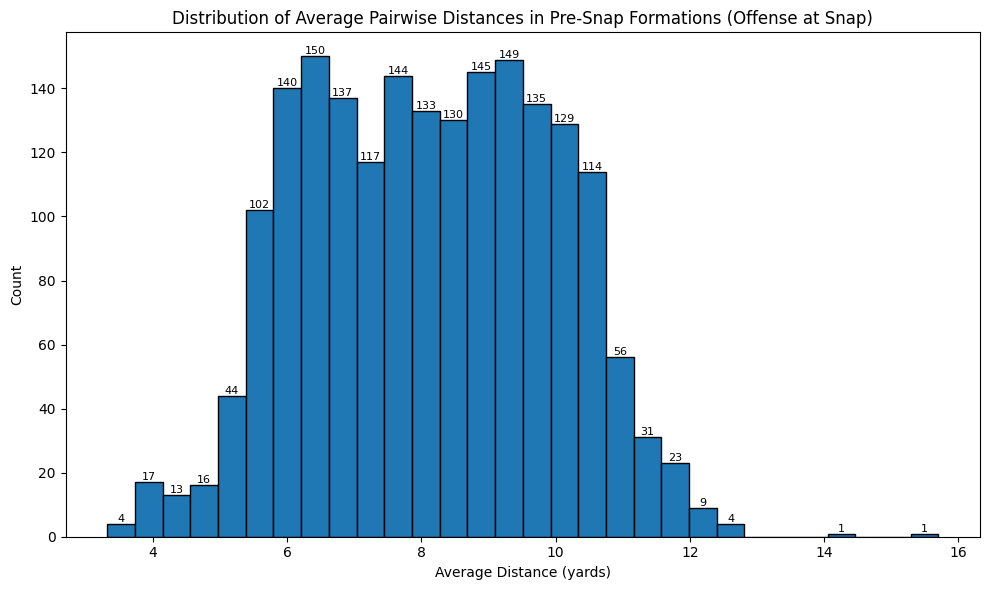


Summary of Formation Statistics:
Average Pairwise Distance: 8.13 yards
Average Formation Spread:  8.03 yards


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def pairwise_avg_distance(coords: np.ndarray) -> float:
    """Average pairwise Euclidean distance for coords shaped (N,2)."""
    if coords.shape[0] < 2:
        return 0.0
    diffs = coords[:, None, :] - coords[None, :, :]
    d = np.sqrt((diffs ** 2).sum(axis=-1))
    n = coords.shape[0]
    triu = d[np.triu_indices(n, k=1)]
    return float(triu.mean()) if triu.size else 0.0

def process_tracking_data(tracking_file, plays_df, player_play_df, chunk_size=100000):
    """
    Process tracking data in chunks to extract SNAP-frame offensive player data
    and compute formation statistics.

    Key fixes:
    - tracking has no 'position' → merge positions from player_play/players
    - side column is 'club' with team abbreviations → drop only 'football'
    - infer offense from QB's club at snap
    """
    print(f"\nProcessing {tracking_file}...")
    tracking_chunks = pd.read_csv(tracking_file, chunksize=chunk_size)

    # Build fallback position lookup from player_play_df (or players_df by nflId)
    pos_col = next((c for c in ["position", "officialPosition", "pff_positionLinedUp"]
                    if c in player_play_df.columns), None)
    if pos_col:
        pp_pos = (player_play_df[["gameId","playId","nflId",pos_col]]
                  .rename(columns={pos_col: "pp_position"}))
    else:
        pp_pos = player_play_df[["gameId","playId","nflId"]].copy()
        if "position" in players_df.columns:
            pp_pos = pp_pos.merge(
                players_df[["nflId","position"]].rename(columns={"position":"pp_position"}),
                on="nflId", how="left"
            )
        else:
            pp_pos["pp_position"] = pd.NA
    pp_pos["pp_position"] = pp_pos["pp_position"].astype("string").str.strip().str.upper()

    pre_snap_frames = []
    formation_stats = {'avg_player_distance': [], 'formation_spread': []}
    row_count = 0

    for chunk in tracking_chunks:
        row_count += len(chunk)

        # Required columns
        needed = {"gameId","playId","nflId","x","y","event"}
        missing = needed - set(chunk.columns)
        if missing:
            raise KeyError(f"tracking chunk missing columns: {missing}")

        # team/side column is 'team' or 'club' (your file uses 'club')
        team_col = "team" if "team" in chunk.columns else ("club" if "club" in chunk.columns else None)
        if team_col is None:
            raise KeyError("tracking chunk missing 'team'/'club' column (team abbrev or 'football')")

        # 1) Snap-frame rows
        pre_snap_chunk = chunk[chunk['event'].astype('string').str.strip().eq('ball_snap')]
        if pre_snap_chunk.empty:
            continue

        # 2) Keep players only: **drop ONLY 'football'**, since values are team abbreviations (IND/HOU/…)
        pre_snap_chunk = pre_snap_chunk[pre_snap_chunk[team_col].astype('string').str.lower() != 'football']
        if pre_snap_chunk.empty:
            continue

        # 3) Merge positions (tracking has no 'position' in your file)
        pre_snap_chunk = pre_snap_chunk.merge(
            pp_pos, on=["gameId","playId","nflId"], how="left"
        )
        pre_snap_chunk["position_final"] = pre_snap_chunk["pp_position"].astype("string").str.strip().str.upper()

        # 4) Per play: find QB row to infer offense side (QB's club), keep only that side
        kept_rows = []
        for (game_id, play_id), group in pre_snap_chunk.groupby(['gameId', 'playId']):
            qb_rows = group[group["position_final"] == "QB"]
            if qb_rows.empty:
                continue  # cannot infer offense side; skip
            offense_side = str(qb_rows.iloc[0][team_col])  # e.g., 'IND', 'HOU', ...
            group_off = group[group[team_col] == offense_side]
            if group_off.empty:
                continue
            kept_rows.append(group_off)

            # 5) Formation stats on the offense at snap
            coords = group_off[['x', 'y']].to_numpy(dtype=np.float32, copy=False)
            if coords.shape[0] > 1:
                avg_dist = pairwise_avg_distance(coords)
                spread   = float(np.std(coords, axis=0).sum())  # std_x + std_y
                formation_stats['avg_player_distance'].append(avg_dist)
                formation_stats['formation_spread'].append(spread)

        if kept_rows:
            pre_snap_frames.append(pd.concat(kept_rows, ignore_index=True))

    return (pd.concat(pre_snap_frames, ignore_index=True) if pre_snap_frames else pd.DataFrame(),
            formation_stats, row_count)

# --- Run (Week 1 example) with your same calls
tracking_df, formation_stats, tracking_row_count = process_tracking_data(
    tracking_files[0], plays_df, player_play_df
)
print(f"Tracking Data Row Count (Week 1): {tracking_row_count}")

if not tracking_df.empty and formation_stats['avg_player_distance']:
    plt.figure(figsize=(10, 6))
    counts, bins, _ = plt.hist(formation_stats['avg_player_distance'], bins=30, edgecolor='black')
    for count, binl, binr in zip(counts.astype(int), bins[:-1], bins[1:]):
        if count > 0:
            plt.text((binl + binr) / 2, count, f'{count}', ha='center', va='bottom', fontsize=8)
    plt.title("Distribution of Average Pairwise Distances in Pre-Snap Formations (Offense at Snap)")
    plt.xlabel("Average Distance (yards)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

print("\nSummary of Formation Statistics:")
if formation_stats['avg_player_distance']:
    print(f"Average Pairwise Distance: {np.mean(formation_stats['avg_player_distance']):.2f} yards")
    print(f"Average Formation Spread:  {np.mean(formation_stats['formation_spread']):.2f} yards")
else:
    print("No formation stats collected (no snap frames or no offense rows).")


## Data Normalization ##

* Load tracking files with essential columns (IDs + movement features).
* Merge player info: add *position*, *offenseDefense*, *playerPlayRole*.
* Attach play labels: *yardsGained*, *passResult*, *playResult*, *playDirection*.
* Standardize field so offense always moves left -> right.
* Select one reference frame per play (ball snap or first frame).
* Transform features: convert angles to sin/cos, scale numeric values.
* Encode categorical columns into integer indices.
* Build feature table & index map for graph construction.

In [26]:
import os, glob
import pandas as pd
import numpy as np

# assumes: data_dir, players_df, plays_df, player_play_df already loaded

# 1) Resolve tracking files (explicit 1..9 if present, else glob)
explicit = [os.path.join(data_dir, f"tracking_week_{i}.csv") for i in range(1, 10)]
globbed  = sorted(glob.glob(os.path.join(data_dir, "tracking_week_*.csv")))
files = explicit if all(os.path.exists(f) for f in explicit) else globbed
if not files:
    raise FileNotFoundError("No tracking_week_*.csv files found.")

# 2) Desired columns + dtypes
# NOTE: add 'club' (many BDB drops use this instead of 'team')
desired = ["gameId","playId","nflId","frameId","event","team","club",
           "x","y","s","a","dis","o","dir","playDirection"]

# Use nullable Int64 for IDs to stay consistent with other frames
read_dtypes = {
    "gameId":"Int64","playId":"Int64","frameId":"Int64","nflId":"Int64",
    "x":"float32","y":"float32","s":"float32","a":"float32","dis":"float32","o":"float32","dir":"float32",
    # event/team/club/playDirection are read as object -> normalized below
}

# 3) Read safely even if some columns are missing (e.g., 'team' or 'club')
tracking_list = []
for f in files:
    df = pd.read_csv(f, usecols=lambda c: c in desired, dtype=read_dtypes, low_memory=False)
    # add any missing desired columns (fill with NA)
    for c in desired:
        if c not in df.columns:
            df[c] = (np.nan if c in ["x","y","s","a","dis","o","dir"] else pd.NA)
    # unify side column: prefer 'team', else 'club'
    side = df["team"].astype("string") if "team" in df.columns else pd.Series(pd.NA, index=df.index, dtype="string")
    club = df["club"].astype("string") if "club" in df.columns else pd.Series(pd.NA, index=df.index, dtype="string")
    df["side"] = side.fillna(club).str.strip()
    # drop only 'football' rows from side now, so later code never sees them
    df = df[df["side"].str.lower() != "football"].copy()
    # reorder to desired order (+ 'side' at the end)
    df = df[desired].assign(side=df["side"])
    tracking_list.append(df)

tracking_df = pd.concat(tracking_list, ignore_index=True)

# 4) Normalize strings & align IDs (avoid categories that break .str ops later)
for c in ["event","playDirection","side","team","club"]:
    if c in tracking_df.columns:
        tracking_df[c] = tracking_df[c].astype("string").str.strip()

# Ensure ID dtypes align across frames (all Int64)
for frame, name in [(tracking_df, "tracking_df"), (players_df, "players_df"), (player_play_df, "player_play_df"), (plays_df, "plays_df")]:
    for col in ["gameId","playId","nflId"]:
        if col in frame.columns:
            frame[col] = pd.to_numeric(frame[col], errors="coerce").astype("Int64")

print('tracking data normalized.')
# (Optional quick sanity prints)
print("event sample:", tracking_df["event"].dropna().unique()[:10])
print("side sample:", tracking_df["side"].dropna().unique()[:10])


tracking data normalized.
event sample: <StringArray>
['huddle_break_offense',             'line_set',        'man_in_motion',
            'ball_snap',              'handoff',        'first_contact',
               'tackle',         'pass_forward',         'pass_arrived',
  'pass_outcome_caught']
Length: 10, dtype: string
side sample: <StringArray>
['DEN', 'SEA', 'TB', 'DAL', 'TEN', 'NYG', 'MIN', 'GB', 'LV', 'LAC']
Length: 10, dtype: string


In [27]:
# sanity test
# Quick sanity: do we have snap rows and can we find a QB using player_play positions?
snap_rows = tracking_df[tracking_df["event"].str.strip().eq("ball_snap")]
print("snap rows:", len(snap_rows))
print("unique plays with snap:", snap_rows[["gameId","playId"]].drop_duplicates().shape[0])

# Build pp_position (fallback path if you haven't already)
pos_col = next((c for c in ["position","officialPosition","pff_positionLinedUp"] if c in player_play_df.columns), None)
if pos_col:
    pp_pos = player_play_df[["gameId","playId","nflId",pos_col]].rename(columns={pos_col:"pp_position"})
else:
    pp_pos = player_play_df[["gameId","playId","nflId"]].merge(
        players_df[["nflId","position"]].rename(columns={"position":"pp_position"}),
        on="nflId", how="left"
    )
pp_pos["pp_position"] = pp_pos["pp_position"].astype("string").str.strip().str.upper()

snap_m = snap_rows.merge(pp_pos, on=["gameId","playId","nflId"], how="left")
qb_plays = snap_m[snap_m["pp_position"]=="QB"][["gameId","playId"]].drop_duplicates()
print("plays with QB@snap:", qb_plays.shape[0])

# optional peek
print("pp_position sample:", snap_m["pp_position"].dropna().unique()[:10])
print("side sample at snap:", snap_m["side"].dropna().unique()[:10] if "side" in snap_m else "(no side column in this DF)")


snap rows: 353364
unique plays with snap: 16062
plays with QB@snap: 16062
pp_position sample: <StringArray>
['SS', 'QB', 'G', 'CB', 'OLB', 'WR', 'DE', 'ILB', 'FS', 'C']
Length: 10, dtype: string
side sample at snap: <StringArray>
['DEN', 'SEA', 'TB', 'DAL', 'TEN', 'NYG', 'MIN', 'GB', 'LV', 'LAC']
Length: 10, dtype: string


# Preprocessing and Feature Engineering

* Pick the reference frame for each play (ball snap or earliest).  
* Pick the reference frame for each play (ball snap or earliest).
* Keep only player rows with valid IDs.
* Merge in position info and create a unified position_final.
* Normalize team side labels.
* Convert orientation/direction angles into cosine/sine features.
* Scale numeric features to standardized float32.
* Map categorical features (like position, side) to integer indices.
* Build a clean feature matrix with IDs, features, and row index.



In [30]:
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 2) Pick reference frame per play
# -----------------------------
snap = (
    tracking_df.loc[tracking_df["event"].astype("string").str.strip().eq("ball_snap"), ["gameId","playId","frameId"]]
    .groupby(["gameId","playId"], sort=False, as_index=False)["frameId"].min()
    .rename(columns={"frameId": "snapFrame"})
)

ref = tracking_df.merge(snap, on=["gameId","playId"], how="left")
ref["useFrame"] = np.where(
    ref["snapFrame"].notna(),
    ref["snapFrame"],
    ref.groupby(["gameId","playId"])["frameId"].transform("min")
)
ref = ref[ref["frameId"] == ref["useFrame"]]

# Keep players only (drop 'football' rows which we removed earlier, plus ensure nflId present)
players_frame = ref[ref["nflId"].notna()].copy()

# ensure consistent ID dtype for later merges/tensors
for c in ("gameId","playId","nflId"):
    if c in players_frame.columns:
        players_frame[c] = pd.to_numeric(players_frame[c], errors="coerce").astype("Int64")

# ===== ADDED: bring positions from player_play_df (fallback to players_df) =====
pos_col = next((c for c in ["position", "officialPosition", "pff_positionLinedUp"]
                if c in player_play_df.columns), None)
if pos_col:
    pp_pos = player_play_df[["gameId","playId","nflId", pos_col]].rename(columns={pos_col: "pp_position"})
else:
    pp_pos = player_play_df[["gameId","playId","nflId"]].copy()
    if "position" in players_df.columns:
        pp_pos = pp_pos.merge(
            players_df[["nflId","position"]].rename(columns={"position":"pp_position"}),
            on="nflId", how="left"
        )
    else:
        pp_pos["pp_position"] = pd.NA

pp_pos["pp_position"] = pp_pos["pp_position"].astype("string").str.strip().str.upper()
players_frame = players_frame.merge(pp_pos, on=["gameId","playId","nflId"], how="left")
# ==============================================================================

# ---- unify position for QB/WR extraction downstream
# prefer existing 'position' if present; else use newly merged 'pp_position'
if "position" in players_frame.columns:
    players_frame["position"] = players_frame["position"].astype("string").str.strip().str.upper()
else:
    players_frame["position"] = pd.Series(pd.NA, index=players_frame.index, dtype="string")

players_frame["position_final"] = (
    players_frame["position"].fillna(players_frame["pp_position"])
).astype("string").str.strip().str.upper()

# Keep side normalized if present (team abbrev)
if "side" in players_frame.columns:
    players_frame["side"] = players_frame["side"].astype("string").str.strip().str.upper()

# -----------------------------
# 3) Numeric + categorical features
# -----------------------------
def ang2vec(deg_series: pd.Series):
    rad = (deg_series.astype(np.float32).to_numpy() * (np.pi / 180.0)).astype(np.float32)
    c = np.cos(rad).astype(np.float32)
    s = np.sin(rad).astype(np.float32)
    return c, s

# Angles → sin/cos
if "o" in players_frame.columns:
    c, s = ang2vec(players_frame["o"]);   players_frame["o_cos"],  players_frame["o_sin"]  = c, s
if "dir" in players_frame.columns:
    c, s = ang2vec(players_frame["dir"]); players_frame["dir_cos"], players_frame["dir_sin"] = c, s

num_cols = [c for c in ["x","y","s","a","dis","o_cos","o_sin","dir_cos","dir_sin"] if c in players_frame.columns]

# Fit scaler here ONLY for a one-shot build; in a real pipeline, fit on train split
if num_cols:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(players_frame[num_cols].fillna(0.0).to_numpy(np.float32))
    scaled = np.nan_to_num(scaled, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    players_frame[num_cols] = scaled

# Categorical → indices (0 is UNK)
def build_vocab(series: pd.Series):
    vals = [v for v in series.dropna().astype(str).unique()]
    return {v: i+1 for i, v in enumerate(sorted(vals))}  # 1..K, with 0 reserved

# include unified position + side so WR/QB & team abbrev are available downstream
cat_candidates = ["position_final", "pp_position", "position", "playerPlayRole", "offenseDefense", "side"]
cat_cols = [c for c in cat_candidates if c in players_frame.columns]

vocabs = {c: build_vocab(players_frame[c].astype("string")) for c in cat_cols}
for c in cat_cols:
    players_frame[f"{c}_idx"] = (
        players_frame[c].astype("string").map(vocabs[c]).fillna(0).astype(np.int32)  # to torch.long later
    )

# Stable key mapping for feature lookup
feat_cols = ["gameId","playId","nflId"] + num_cols + [f"{c}_idx" for c in cat_cols]
feat_df = players_frame[feat_cols].reset_index(drop=True)
feat_df["__row_ix__"] = np.arange(len(feat_df), dtype=np.int64)

# (gameId, playId, nflId) -> row index
key_to_ix = dict(zip(zip(feat_df["gameId"], feat_df["playId"], feat_df["nflId"]), feat_df["__row_ix__"]))

# Dense numeric matrix (float32 for CUDA)
num_mat = (
    feat_df[num_cols].to_numpy(dtype=np.float32)
    if num_cols else np.zeros((len(feat_df), 0), dtype=np.float32)
)

# Optional CUDA-safety sanity checks
if num_cols:
    assert np.isfinite(num_mat).all(), "Non-finite values in numeric features after scaling."
assert feat_df[["gameId","playId","nflId"]].drop_duplicates().shape[0] == len(feat_df), \
    "Duplicate (gameId,playId,nflId) rows found."
for c in cat_cols:
    idx = feat_df[f"{c}_idx"].to_numpy()
    assert idx.min() >= 0, f"Negative index in {c}_idx."

print('data preparation complete.')


data preparation complete.


In [31]:
# ===== SANITY CHECKS =====

print("\n=== Basic shapes ===")
print("feat_df shape:", feat_df.shape)
print("num_mat shape:", num_mat.shape)
print("num_cols:", num_cols)
print("cat_cols:", cat_cols)

# 1) Uniqueness & keys
print("\n=== Key uniqueness ===")
n_keys = feat_df[["gameId","playId","nflId"]].shape[0]
n_unique_keys = feat_df[["gameId","playId","nflId"]].drop_duplicates().shape[0]
print("rows:", n_keys, "unique (gameId,playId,nflId):", n_unique_keys)
assert n_keys == n_unique_keys, "Duplicate (gameId,playId,nflId) rows found in feat_df."

# 2) Reference frame selection sanity (snap or earliest)
print("\n=== Reference frame selection ===")
# Expect exactly one frame per (gameId,playId,nflId) in players_frame
counts_per_entity = players_frame.groupby(["gameId","playId","nflId"], as_index=False).size()["size"]
print("entities with >1 rows at reference frame:", int((counts_per_entity > 1).sum()))
assert (counts_per_entity <= 1).all(), "An entity has multiple rows in reference frame."

# 3) Side / team abbrev presence
if "side" in players_frame.columns:
    sides = players_frame["side"].dropna().unique()
    print("\n=== Side values sample ===")
    print(sides[:12])
    # should NOT contain 'football'
    assert not any(str(s).lower() == "football" for s in sides), "'football' leaked into players_frame.side"

# 4) Position labels available for QB/WR logic
print("\n=== Position label coverage ===")
pos_col_used = "position_final" if "position_final" in players_frame.columns else (
    "pp_position" if "pp_position" in players_frame.columns else ("position" if "position" in players_frame.columns else None)
)
print("position column used:", pos_col_used)
assert pos_col_used is not None, "No position column available (need position_final/pp_position/position)."

pos_vc = players_frame[pos_col_used].value_counts(dropna=True).head(10)
print("top positions:\n", pos_vc)

# 5) QB at reference frame (should be near #unique plays)
qb_per_play = players_frame[players_frame[pos_col_used] == "QB"].groupby(["gameId","playId"]).size()
print("\nplays with QB at ref frame:", qb_per_play.shape[0])

# 6) WR availability (you can still mine pairs even if some plays have 0 WRs)
wr_per_play = players_frame[players_frame[pos_col_used] == "WR"].groupby(["gameId","playId"]).size()
print("plays with >=1 WR at ref frame:", wr_per_play.shape[0])

# 7) Numeric matrix dtype/finities (CUDA safety)
print("\n=== Numeric features (CUDA safety) ===")
if num_cols:
    print("num_mat dtype:", num_mat.dtype)
    assert num_mat.dtype == np.float32, "num_mat should be float32."
    assert np.isfinite(num_mat).all(), "Non-finite values present in num_mat."
else:
    print("No numeric columns; num_mat empty.")

# 8) Categorical indices validity
print("\n=== Categorical indices ===")
for c in cat_cols:
    arr = players_frame[f"{c}_idx"].to_numpy()
    print(f"{c}_idx min/max:", int(arr.min()), int(arr.max()), " (0=UNK)")
    assert arr.min() >= 0, f"Negative index found in {c}_idx."

# 9) ID dtypes (prevent float promotion later)
print("\n=== ID dtypes ===")
for col in ["gameId","playId","nflId"]:
    if col in feat_df.columns:
        print(col, feat_df[col].dtype)

# 10) Quick per-play roster size at ref frame (sanity)
sizes = players_frame.groupby(["gameId","playId"]).size()
print("\nper-play count (min/mean/max):", int(sizes.min()), float(sizes.mean()), int(sizes.max()))

# 11) Tiny preview: build (qbId, wrId) pairs for 3 random plays to confirm mapping
print("\n=== Sample QB–WR pairs (3 plays) ===")
sample_pairs = []
for (gid, pid), grp in players_frame.groupby(["gameId","playId"]):
    qb = grp.loc[grp[pos_col_used] == "QB", "nflId"]
    wrs = grp.loc[grp[pos_col_used] == "WR", "nflId"]
    if not qb.empty and not wrs.empty:
        for wr in wrs.head(2):  # cap to 2 for brevity
            sample_pairs.append((int(gid), int(pid), int(qb.iloc[0]), int(wr)))
    if len(sample_pairs) >= 6:
        break
print(sample_pairs if sample_pairs else "No QB–WR pairs found in sample (check positions).")

print("\nSanity checks complete")



=== Basic shapes ===
feat_df shape: (354728, 17)
num_mat shape: (354728, 9)
num_cols: ['x', 'y', 's', 'a', 'dis', 'o_cos', 'o_sin', 'dir_cos', 'dir_sin']
cat_cols: ['position_final', 'pp_position', 'position', 'side']

=== Key uniqueness ===
rows: 354728 unique (gameId,playId,nflId): 354728

=== Reference frame selection ===
entities with >1 rows at reference frame: 0

=== Side values sample ===
<StringArray>
['DEN', 'SEA', 'TB', 'DAL', 'TEN', 'NYG', 'MIN', 'GB', 'LV', 'LAC', 'KC',
 'ARI']
Length: 12, dtype: string

=== Position label coverage ===
position column used: position_final
top positions:
 position_final
CB     42239
WR     40940
T      32468
G      31238
OLB    23345
DE     22988
ILB    21921
DT     21461
TE     20996
FS     18235
Name: count, dtype: Int64

plays with QB at ref frame: 16123
plays with >=1 WR at ref frame: 16044

=== Numeric features (CUDA safety) ===
num_mat dtype: float32

=== Categorical indices ===
position_final_idx min/max: 0 19  (0=UNK)
pp_position_id

In [32]:
import sys, subprocess, textwrap, os, platform

# -- 1) Uninstall any mismatched builds
subprocess.run([sys.executable, "-m", "pip", "-q", "uninstall", "-y",
                "pyg-lib", "torch-scatter", "torch-sparse", "torch-cluster",
                "torch-spline-conv", "torch-geometric"], check=False)
subprocess.run([sys.executable, "-m", "pip", "-q", "uninstall", "-y",
                "torch", "torchvision", "torchaudio"], check=False)

# -- 2) Install Torch 2.5.1 (CUDA 12.1)
subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", "-q",
                       "torch==2.5.1", "torchvision==0.20.1", "torchaudio==2.5.1",
                       "--index-url", "https://download.pytorch.org/whl/cu121"])

# -- 3) Install PyG wheels matching Torch 2.5.1+cu121
subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", "-q",
                       "pyg-lib", "torch-scatter", "torch-sparse", "torch-cluster",
                       "torch-spline-conv", "torch-geometric",
                       "-f", "https://data.pyg.org/whl/torch-2.5.1+cu121.html"])

# -- 4) Post-install sanity checks (versions, CUDA, and a tiny GraphSAGE forward)
import torch, torch_geometric
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
print("torch          :", torch.__version__, "| cuda:", torch.version.cuda, "| is_available:", torch.cuda.is_available())
print("torch_geometric:", torch_geometric.__version__)

if torch.cuda.is_available():
    try:
        print("cuda device    :", torch.cuda.get_device_name(0))
    except Exception as e:
        print("cuda device    : <unavailable>", e)

# minimal PyG forward pass
x = torch.randn(6, 8)
edge_index = torch.tensor([[0,1,2,3,4,5,0,2,4,1,3,5],
                           [1,0,3,2,5,4,2,0,1,3,5,4]], dtype=torch.long)
conv = SAGEConv(in_channels=8, out_channels=4)
with torch.no_grad():
    out = conv(x, edge_index)
print("SAGEConv OK, out shape:", tuple(out.shape))

# -- 5) Optional CPU fallback helper (run only if torch.cuda.is_available() is False)
if not torch.cuda.is_available():
    print("\n[INFO] CUDA not available. If you want CPU-only wheels, run this:")
    print(textwrap.dedent(f"""
        {sys.executable} -m pip install --no-cache-dir -q \
          torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 \
          --index-url https://download.pytorch.org/whl/cpu

        {sys.executable} -m pip install --no-cache-dir -q torch-geometric \
          -f https://data.pyg.org/whl/torch-2.5.1+cpu.html
    """))


torch          : 2.5.1+cu121 | cuda: 12.1 | is_available: True
torch_geometric: 2.6.1
cuda device    : Tesla T4
SAGEConv OK, out shape: (6, 4)


In [33]:
import torch, torch_geometric
print("Torch:", torch.__version__, "| wheel CUDA:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
print("PyG:", torch_geometric.__version__)


Torch: 2.5.1+cu121 | wheel CUDA: 12.1
GPU: Tesla T4
PyG: 2.6.1


# Graph Construction

* Build one graph per play (using snap frame player data).
* Keep offense-only players (exclude defense + football).
* Add edges using radius and/or k-NN proximity.
* Always connect QB <-> WR nodes explicitly.
* Attach node features (numeric + categorical indices).
* Store graph labels from play outcomes (e.g., winning pass).
* Package everything into PyTorch Geometric Data objects.


In [56]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph

# --- tuning knobs (football-meaningful defaults) ---
KNN_K         = 3                 # fallback k for sparse plays
MIN_PLAYERS   = 8                 # offense-only often ~11; tolerate a bit less
ADAPTIVE_PCTL = 30                # percentile for adaptive radius (tighter than 35)
R_MIN, R_MAX  = 2.5, 4.5          # clip radius into this band (yards)
DENSITY_CAP   = 0.48              # prune if graph is denser than this (was 0.50)
DEGREE_CAP    = 2                 # cap degree per node when pruning (was 3)
RECEIVER_POS  = {"WR", "TE", "RB"}  # include RB as receiver fallback

# --- Labels assumed precomputed on plays_df ---
#   plays_df["isWinningPass"] (completed & yardsGained > 0)
#   plays_df["isCompletedZeroGain"] (completed & yardsGained == 0)
plays_lbl = plays_df[["gameId","playId","isWinningPass","isCompletedZeroGain"]].copy()
plays_lbl["isWinningPass"] = plays_lbl["isWinningPass"].fillna(False).astype(bool)
plays_lbl["isCompletedZeroGain"] = plays_lbl["isCompletedZeroGain"].fillna(False).astype(bool)
label_map = {
    (int(r.gameId), int(r.playId)): (bool(r.isWinningPass), bool(r.isCompletedZeroGain))
    for r in plays_lbl.itertuples()
}

def build_graph_with_indices(play_df):
    req = {"x","y","gameId","playId","nflId","side","position_final"}
    if not req.issubset(play_df.columns):
        return None

    # --- Offense-only: infer offense side from QB
    qbs = play_df[play_df["position_final"] == "QB"]
    if qbs.empty:
        return None
    offense_side = str(qbs["side"].iloc[0])
    pdf = (play_df[(play_df["side"] == offense_side)]
           .dropna(subset=["x","y"])
           .drop_duplicates(subset=["nflId"], keep="first")
           .sort_values("nflId"))
    if len(pdf) < MIN_PLAYERS:
        return None

    # --- Node coords (float32, finite)
    coords = pdf[["x","y"]].to_numpy(dtype=np.float32, copy=False)
    coords = np.nan_to_num(coords, nan=0.0, posinf=0.0, neginf=0.0)
    assert np.isfinite(coords).all(), "Non-finite values in coords."
    num_nodes = len(pdf)

    # --- Pairwise distances once (yards)
    if num_nodes > 1:
        diff = coords[:, None, :] - coords[None, :, :]
        dist = np.sqrt((diff ** 2).sum(axis=-1))
    else:
        dist = None

    # --- Base edges (adaptive, sparse)
    edges = set()

    # 1) Adaptive radius (30th percentile of nonzero distances), clipped to [2.5, 4.5] yds
    if dist is not None:
        nz = dist[dist > 0]
        if nz.size:
            R = float(np.clip(np.percentile(nz, ADAPTIVE_PCTL), R_MIN, R_MAX))
            i, j = np.where((dist <= R) & (dist > 0))
            for u, v in zip(i, j):
                edges.add((min(u, v), max(u, v)))

    # 2) Explicit QB → receiver edges with fallbacks (WR → TE → RB → nearest 2)
    qb_mask  = (pdf["position_final"] == "QB").to_numpy()
    pos_vals = pdf["position_final"].to_numpy()
    recv_mask = np.isin(pos_vals, list(RECEIVER_POS))
    if qb_mask.any():
        qb_idx = int(np.where(qb_mask)[0][0])

        added_any = False
        # Try WR first, then TE, then RB
        for want in ("WR", "TE", "RB"):
            idxs = np.where(pos_vals == want)[0]
            idxs = idxs[idxs != qb_idx]
            if idxs.size > 0:
                for r_idx in idxs:
                    edges.add((min(qb_idx, r_idx), max(qb_idx, r_idx)))
                added_any = True
                break

        # Final fallback: nearest 2 teammates by distance
        if not added_any and dist is not None:
            order = np.argsort(dist[qb_idx])
            added = 0
            for v in order:
                if v == qb_idx:
                    continue
                edges.add((min(qb_idx, v), max(qb_idx, v)))
                added += 1
                if added >= 2:
                    break

    # 3) If too sparse, fallback to symmetric kNN (k=3 by default)
    def _avg_degree(e_count, n): return (2.0 * e_count) / n if n > 0 else 0.0
    if num_nodes > 1:
        avg_deg = _avg_degree(len(edges), num_nodes)
        if avg_deg < 1.5:
            k = int(min(KNN_K, num_nodes - 1))
            if k >= 1:
                A = kneighbors_graph(coords, n_neighbors=k, mode="connectivity", include_self=False)
                A = A.maximum(A.T)
                rows, cols = A.nonzero()
                for u, v in zip(rows, cols):
                    edges.add((min(u, v), max(u, v)))

    if not edges:
        return None

    # 4) If too dense, prune degree to DEGREE_CAP (keep QB→receiver edges)
    def _density(e_count, n): return (2.0 * e_count) / (n * (n - 1)) if n > 1 else 0.0
    density = _density(len(edges), num_nodes)
    if density > DENSITY_CAP and dist is not None:
        E = set(edges)
        pruned = set()
        qb_mask = (pdf["position_final"] == "QB").to_numpy()
        pos_vals = pdf["position_final"].to_numpy()
        recv_mask = np.isin(pos_vals, list(RECEIVER_POS))

        for u in range(num_nodes):
            kept = 0
            # keep QB↔receiver edges first
            for v in range(num_nodes):
                if v == u:
                    continue
                e = (min(u, v), max(u, v))
                is_qb_recv = (qb_mask[u] and recv_mask[v]) or (qb_mask[v] and recv_mask[u])
                if is_qb_recv and e in E:
                    pruned.add(e); kept += 1
                    if kept >= DEGREE_CAP:
                        break
            # fill with nearest neighbors up to cap
            if kept < DEGREE_CAP:
                order = np.argsort(dist[u])
                for v in order:
                    if v == u:
                        continue
                    e = (min(u, v), max(u, v))
                    if e in E and e not in pruned:
                        pruned.add(e); kept += 1
                    if kept >= DEGREE_CAP:
                        break
        edges = pruned

    if not edges:
        return None

    edge_index = torch.tensor(np.array(list(edges)).T, dtype=torch.long)  # shape [2, E]

    # --- Map to global feature rows
    try:
        row_ix = [key_to_ix[(int(r.gameId), int(r.playId), int(r.nflId))] for r in pdf.itertuples()]
    except KeyError:
        return None

    # --- Node features (float32)
    if len(num_cols) > 0:
        x_np = num_mat[row_ix]
        x_np = np.nan_to_num(x_np, nan=0.0, posinf=0.0, neginf=0.0)
        assert np.isfinite(x_np).all(), "Non-finite values in x."
        x = torch.from_numpy(x_np.astype(np.float32, copy=False))
    else:
        x = torch.zeros((num_nodes, 0), dtype=torch.float32)

    # --- Play labels from plays_df
    gid, pid = int(pdf["gameId"].iloc[0]), int(pdf["playId"].iloc[0])
    win_pass, comp_zero = label_map.get((gid, pid), (False, False))
    y  = torch.tensor([1 if win_pass  else 0], dtype=torch.long)  # primary label
    z0 = torch.tensor([1 if comp_zero else 0], dtype=torch.long)  # completed-zero-gain flag

    data = Data(
        x=x,
        edge_index=edge_index,
        y=y,
        gameId=torch.tensor([gid], dtype=torch.long),
        playId=torch.tensor([pid], dtype=torch.long),
        z0=z0,  # auxiliary attribute
    )

    # --- Attach per-node categorical indices (long)
    for c in cat_cols:
        col = f"{c}_idx"
        if col in feat_df.columns:
            node_idx = feat_df.loc[row_ix, col].to_numpy(dtype=np.int64, copy=False)
            assert node_idx.min() >= 0, f"Negative index in {col}."
            data[col] = torch.as_tensor(node_idx, dtype=torch.long)

    # --- Attach node nflId so we can mine QB↔receiver pairs later
    nid = pdf["nflId"].astype("Int64").fillna(-1).to_numpy(np.int64, copy=False)
    data.nflId = torch.as_tensor(nid, dtype=torch.long)

    assert data.x.dtype == torch.float32
    assert data.edge_index.dtype == torch.long
    return data

# Build graphs per play
graphs = []
for (gid, pid), grp in players_frame.groupby(["gameId","playId"], sort=False):
    g = build_graph_with_indices(grp)
    if g is not None:
        graphs.append(g)

print(f"Built {len(graphs)} graphs. Example x-dim = {graphs[0].x.shape[1] if graphs else 0}")
print('Graph constructed.')


Built 16123 graphs. Example x-dim = 9
Graph constructed.


In [57]:
import numpy as np, torch

recv_vocab = vocabs["position_final"]
QB = recv_vocab.get("QB", -1)
WR = recv_vocab.get("WR", -1)
TE = recv_vocab.get("TE", -1)
RB = recv_vocab.get("RB", -1)

total = len(graphs)
with_wr = with_te = with_rb = 0
qb_has_edge = 0
qb_to_any_receiver = 0
qb_to_wr = qb_to_te = qb_to_rb = 0

for g in graphs:
    pos = g["position_final_idx"] if "position_final_idx" in g else None
    if pos is None:
        continue

    wr_nodes = (pos == WR).nonzero(as_tuple=False).flatten().tolist()
    te_nodes = (pos == TE).nonzero(as_tuple=False).flatten().tolist()
    rb_nodes = (pos == RB).nonzero(as_tuple=False).flatten().tolist()
    qb_nodes = (pos == QB).nonzero(as_tuple=False).flatten().tolist()

    if wr_nodes: with_wr += 1
    if te_nodes: with_te += 1
    if rb_nodes: with_rb += 1
    if not qb_nodes:
        continue

    u = qb_nodes[0]

    # Build neighbor set for THIS QB only
    ei = g.edge_index
    neighbors = set()
    # edges are undirected, so check both ends
    for a, b in ei.t().tolist():
        if a == u and b != u:
            neighbors.add(b)
        elif b == u and a != u:
            neighbors.add(a)

    if neighbors:
        qb_has_edge += 1

    wr_hit = any(v in neighbors for v in wr_nodes)
    te_hit = any(v in neighbors for v in te_nodes)
    rb_hit = any(v in neighbors for v in rb_nodes)

    if wr_hit or te_hit or rb_hit:
        qb_to_any_receiver += 1
    if wr_hit: qb_to_wr += 1
    if te_hit: qb_to_te += 1
    if rb_hit: qb_to_rb += 1

print("\n=== Receiver presence across graphs ===")
print(f"with WR: {with_wr} / {total}")
print(f"with TE: {with_te} / {total}")
print(f"with RB: {with_rb} / {total}")

print("\n=== QB connectivity ===")
print(f"QB has at least 1 neighbor: {qb_has_edge} / {total}")
print(f"QB connected to ANY (WR/TE/RB): {qb_to_any_receiver} / {total}")
print(f"QB→WR: {qb_to_wr} / {total} | QB→TE: {qb_to_te} / {total} | QB→RB: {qb_to_rb} / {total}")



=== Receiver presence across graphs ===
with WR: 16043 / 16123
with TE: 15929 / 16123
with RB: 15913 / 16123

=== QB connectivity ===
QB has at least 1 neighbor: 16123 / 16123
QB connected to ANY (WR/TE/RB): 16123 / 16123
QB→WR: 16043 / 16123 | QB→TE: 15737 / 16123 | QB→RB: 15616 / 16123


In [59]:
from collections import Counter

QB = vocabs["position_final"].get("QB", -1)
WR = vocabs["position_final"].get("WR", -1)
TE = vocabs["position_final"].get("TE", -1)
RB = vocabs["position_final"].get("RB", -1)

winners = Counter()
zero_gains = Counter()

for g in graphs:
    if "position_final_idx" not in g or not hasattr(g, "nflId"):
        continue
    pos = g["position_final_idx"]
    qb_nodes = (pos == QB).nonzero().flatten().tolist()
    if not qb_nodes:
        continue
    u = qb_nodes[0]

    # receiver priority: WR -> TE -> RB
    recv_nodes = (pos == WR).nonzero().flatten().tolist()
    if not recv_nodes:
        recv_nodes = (pos == TE).nonzero().flatten().tolist()
    if not recv_nodes:
        recv_nodes = (pos == RB).nonzero().flatten().tolist()
    if not recv_nodes:
        continue

    E = {tuple(e) for e in g.edge_index.t().tolist()}
    for v in recv_nodes:
        if v == u:
            continue
        if (min(u, v), max(u, v)) in E:
            pair = (int(g.nflId[u].item()), int(g.nflId[v].item()))
            if int(g.y.item()) == 1:
                winners[pair] += 1
            if hasattr(g, "z0") and int(g.z0.item()) == 1:
                zero_gains[pair] += 1

# Show top results (join to names if desired)
id2name = dict(zip(players_df["nflId"].astype("Int64"), players_df["displayName"]))
fmt = lambda pid: id2name.get(pid, f"ID:{pid}")

print("Top QB–Receiver pairs on WINNING passes:")
for (qb, rc), n in winners.most_common(20):
    print(f"{fmt(qb)} -> {fmt(rc)}: {n} yards.")

print("\nPairs with most COMPLETED zero-gain passes:")
for (qb, rc), n in zero_gains.most_common(10):
    print(f"{fmt(qb)} -> {fmt(rc)}: {n} yards.")


Top QB–Receiver pairs on WINNING passes:
Joe Burrow -> Tyler Boyd: 194 yards.
Tom Brady -> Mike Evans: 185 yards.
Matthew Stafford -> Cooper Kupp: 181 yards.
Kirk Cousins -> Justin Jefferson: 175 yards.
Patrick Mahomes -> JuJu Smith-Schuster: 174 yards.
Matthew Stafford -> Allen Robinson: 173 yards.
Trevor Lawrence -> Christian Kirk: 172 yards.
Kirk Cousins -> Adam Thielen: 169 yards.
Matt Ryan -> Parris Campbell: 169 yards.
Joe Burrow -> Ja'Marr Chase: 168 yards.
Matt Ryan -> Michael Pittman: 167 yards.
Joe Burrow -> Tee Higgins: 164 yards.
Patrick Mahomes -> Marquez Valdes-Scantling: 159 yards.
Justin Herbert -> Josh Palmer: 156 yards.
Derek Carr -> Davante Adams: 154 yards.
Tom Brady -> Chris Godwin: 153 yards.
Trevor Lawrence -> Zay Jones: 152 yards.
Justin Herbert -> Mike Williams: 149 yards.
Justin Herbert -> DeAndre Carter: 148 yards.
Geno Smith -> Tyler Lockett: 146 yards.

Pairs with most COMPLETED zero-gain passes:
Kirk Cousins -> Adam Thielen: 7 yards.
Kirk Cousins -> Justin

# DataSet Preparation

* Defines a custom NFLGraphDataset class using PyTorch Geometric’s InMemoryDataset for efficient graph storage/loading.

* Normalizes graph attributes (e.g., x as float32, edge_index as long, y/z0 reshaped, categorical indices as long).

* Ensures graph integrity: edges are coalesced (deduped), num_nodes is set, and IDs are aligned.

* Splits games into train (70%), validation (15%), and test (15%) sets by gameId to avoid leakage.

* Creates DataLoaders with shuffle for training and pinned memory for efficient CUDA transfers.

In [78]:
import os
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import coalesce

# -----------------------------
# Pre-sanitize all graphs (uniform fields/dtypes)
# -----------------------------
def sanitize_graphs(graph_list):
    fixed = []
    for d in graph_list:
        # x: [N,F] float32
        if not hasattr(d, "x") or d.x is None:
            raise ValueError("Graph missing x features.")
        d.x = d.x.to(torch.float32)

        # edge_index: [2,E] long, coalesced; num_nodes
        if not hasattr(d, "edge_index") or d.edge_index is None:
            raise ValueError("Graph missing edge_index.")
        d.edge_index = d.edge_index.to(torch.long)
        if getattr(d, "num_nodes", None) is None:
            d.num_nodes = d.x.size(0)
        d.edge_index, _ = coalesce(d.edge_index, None, d.num_nodes)

        # scalar IDs + labels: shape [1], long
        for k in ("gameId", "playId", "y", "z0"):
            v = getattr(d, k, None)
            if v is None:
                setattr(d, k, torch.tensor([0], dtype=torch.long))
            else:
                setattr(d, k, v.view(1).to(torch.long))

        # categorical *_idx -> long
        for k, v in list(d):
            if k.endswith("_idx") and torch.is_tensor(v):
                d[k] = v.to(torch.long)

        # optional node nflIds
        if hasattr(d, "nflId") and d.nflId is not None:
            d.nflId = d.nflId.to(torch.long)

        fixed.append(d)
    return fixed

graphs = sanitize_graphs(graphs)

# -----------------------------
# Train/Val/Test split by gameId (no leakage)
# -----------------------------
def _gid(g):
    return int(g.gameId.item()) if torch.is_tensor(g.gameId) else int(g.gameId)

all_games = sorted({ _gid(g) for g in graphs })
n = len(all_games)
n_train = int(0.7 * n)
n_val   = int(0.15 * n)

train_gids = set(all_games[:n_train])
val_gids   = set(all_games[n_train:n_train + n_val])
test_gids  = set(all_games[n_train + n_val:])

train_graphs = [g for g in graphs if _gid(g) in train_gids]
val_graphs   = [g for g in graphs if _gid(g) in val_gids]
test_graphs  = [g for g in graphs if _gid(g) in test_gids]

# Safety: ensure non-empty splits
if not train_graphs:
    mv = min(5, len(val_graphs))
    train_graphs = val_graphs[:mv] + train_graphs
    val_graphs   = val_graphs[mv:]

# -----------------------------
# DataLoaders (no InMemoryDataset; simple & robust)
# -----------------------------
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True,  pin_memory=True, num_workers=0)
val_loader   = DataLoader(val_graphs,   batch_size=64, shuffle=False, pin_memory=True, num_workers=0)
test_loader  = DataLoader(test_graphs,  batch_size=64, shuffle=False, pin_memory=True, num_workers=0)

print(f"Dataset prepared (no caching). Train/Val/Test: {len(train_graphs)}/{len(val_graphs)}/{len(test_graphs)}")

# -----------------------------
# Quick sanity (index-based)
# -----------------------------
g0 = train_graphs[0] if train_graphs else graphs[0]
print("\nFirst graph sanity:")
print("  gameId/playId:", int(g0.gameId.item()), int(g0.playId.item()))
print("  num_nodes/edges:", g0.num_nodes, g0.edge_index.size(1))
print("  x dim:", g0.x.shape[1])
print("  y/z0:", g0.y.tolist(), (g0.z0.tolist() if 'z0' in g0 else None))

# Optional: one mini-batch check
batch = next(iter(train_loader))
print("\nOne training batch:")
print("  batch.x:", tuple(batch.x.shape))
print("  batch.edge_index:", tuple(batch.edge_index.shape))
print("  batch.y:", tuple(batch.y.shape))


Dataset prepared (no caching). Train/Val/Test: 11280/2380/2463

First graph sanity:
  gameId/playId: 2022091200 64
  num_nodes/edges: 11 20
  x dim: 9
  y/z0: [0] [0]

One training batch:
  batch.x: (352, 9)
  batch.edge_index: (2, 640)
  batch.y: (32,)


In [79]:
import math, numpy as np, torch

# ---------- 0) Basic counts ----------
print("Counts — graphs/train/val/test:",
      len(graphs), len(train_graphs), len(val_graphs), len(test_graphs))
assert len(graphs) > 0, "No graphs!"
assert len(train_graphs) > 0, "Empty train split."

# ---------- 1) Single-graph checks ----------
g0 = train_graphs[0] if train_graphs else graphs[0]
def _chk_graph(g, name="graph"):
    assert hasattr(g, "x") and g.x.ndim == 2, f"{name}: x bad"
    assert hasattr(g, "edge_index") and g.edge_index.ndim == 2 and g.edge_index.size(0) == 2, f"{name}: edge_index bad"
    assert hasattr(g, "gameId") and g.gameId.numel() == 1, f"{name}: gameId missing"
    assert hasattr(g, "playId") and g.playId.numel() == 1, f"{name}: playId missing"
    assert hasattr(g, "y") and g.y.numel() == 1, f"{name}: y missing"
    assert hasattr(g, "z0") and g.z0.numel() == 1, f"{name}: z0 missing"
    assert g.x.dtype == torch.float32, f"{name}: x dtype not float32"
    assert g.edge_index.dtype == torch.long, f"{name}: edge_index dtype not long"
    assert torch.isfinite(g.x).all(), f"{name}: non-finite in x"
    # density sanity
    n = g.num_nodes
    e = g.edge_index.size(1)
    dens = (2.0 * e) / (n * (n - 1)) if n > 1 else 0.0
    print(f"{name}: gid/pid={int(g.gameId.item())}/{int(g.playId.item())} | N={n} E={e} dens={dens:.3f} | xdim={g.x.shape[1]} | y={int(g.y.item())} z0={int(g.z0.item())}")
_chk_graph(g0, "g0")

# ---------- 2) Scan a small sample ----------
def _density(n,e): return (2.0*e)/(n*(n-1)) if n>1 else 0.0
sample_idx = np.linspace(0, len(train_graphs)-1, num=min(50, len(train_graphs)), dtype=int)
densities = []
for i in sample_idx:
    g = train_graphs[i]
    _chk_graph(g, f"train[{i}]")
    densities.append(_density(g.num_nodes, g.edge_index.size(1)))
print(f"Sample density — min/mean/max: {min(densities):.3f}/{np.mean(densities):.3f}/{max(densities):.3f}")

# ---------- 3) Label distribution (train/val/test) ----------
def _labels(lst):
    return [int(g.y.item()) for g in lst]
for name, lst in [("train", train_graphs), ("val", val_graphs), ("test", test_graphs)]:
    ys = _labels(lst)
    if ys:
        pos = sum(ys); neg = len(ys)-pos
        print(f"{name} labels — total={len(ys)} pos={pos} neg={neg} pos%={100*pos/len(ys):.1f}%")
    else:
        print(f"{name} labels — empty split")

# ---------- 4) QB→receiver connectivity sanity ----------
recv_vocab = vocabs["position_final"]
QB = recv_vocab.get("QB", -1); WR = recv_vocab.get("WR", -1); TE = recv_vocab.get("TE", -1); RB = recv_vocab.get("RB", -1)

def qb_connected_to_receiver(g):
    if "position_final_idx" not in g: return False
    pos = g["position_final_idx"]
    qb_nodes = (pos == QB).nonzero().flatten().tolist()
    if not qb_nodes: return False
    u = qb_nodes[0]
    rec = set((pos == WR).nonzero().flatten().tolist()
            + (pos == TE).nonzero().flatten().tolist()
            + (pos == RB).nonzero().flatten().tolist())
    E = {tuple(e) for e in g.edge_index.t().tolist()}
    return any((min(u,v), max(u,v)) in E for v in rec)

conn_counts = sum(qb_connected_to_receiver(g) for g in graphs)
print(f"QB connected to a receiver in {conn_counts}/{len(graphs)} graphs")

# ---------- 5) Mini-batch loader sanity ----------
batch = next(iter(train_loader))
print("\nBatch sanity:")
print("  batch.x shape       :", tuple(batch.x.shape))
print("  batch.edge_index    :", tuple(batch.edge_index.shape))
print("  batch.y shape       :", tuple(batch.y.shape))
print("  batch.num_graphs    :", batch.num_graphs)
assert batch.x.dtype == torch.float32 and batch.edge_index.dtype == torch.long
assert torch.isfinite(batch.x).all(), "Non-finite values in batch.x"

# ---------- 6) Optional CUDA transfer smoke test ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
try:
    b = batch.to(device)
    # simple tensor ops to confirm OK on device
    _ = b.x.mean().item()
    print(f"CUDA smoke test: moved batch to {device} and computed mean OK.")
except Exception as e:
    print("CUDA smoke test failed:", repr(e))


Counts — graphs/train/val/test: 16123 11280 2380 2463
g0: gid/pid=2022091200/64 | N=11 E=20 dens=0.364 | xdim=9 | y=0 z0=0
train[0]: gid/pid=2022091200/64 | N=11 E=20 dens=0.364 | xdim=9 | y=0 z0=0
train[230]: gid/pid=2022091108/104 | N=11 E=20 dens=0.364 | xdim=9 | y=0 z0=0
train[460]: gid/pid=2022091111/360 | N=11 E=20 dens=0.364 | xdim=9 | y=0 z0=0
train[690]: gid/pid=2022091109/251 | N=11 E=20 dens=0.364 | xdim=9 | y=0 z0=0
train[920]: gid/pid=2022091107/3742 | N=11 E=20 dens=0.364 | xdim=9 | y=0 z0=0
train[1150]: gid/pid=2022091105/3316 | N=11 E=20 dens=0.364 | xdim=9 | y=0 z0=0
train[1381]: gid/pid=2022091103/1471 | N=11 E=20 dens=0.364 | xdim=9 | y=0 z0=0
train[1611]: gid/pid=2022091101/417 | N=11 E=20 dens=0.364 | xdim=9 | y=0 z0=0
train[1841]: gid/pid=2022090800/167 | N=11 E=20 dens=0.364 | xdim=9 | y=1 z0=0
train[2071]: gid/pid=2022091900/256 | N=11 E=20 dens=0.364 | xdim=9 | y=1 z0=0
train[2301]: gid/pid=2022091811/1052 | N=11 E=20 dens=0.364 | xdim=9 | y=1 z0=0
train[2532]:

In [ ]:
# -----------------------------
# 7) GraphSAGE with categorical embeddings (CUDA-safe)
# -----------------------------
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.loader import DataLoader
import numpy as np

# --- Derive vocab sizes from actual graphs (safer than feat_df alone) ---
def max_from_graphs(attr_name, graphs):
    mx = -1
    for g in graphs:
        if hasattr(g, attr_name) and getattr(g, attr_name) is not None:
            t = getattr(g, attr_name)
            if torch.is_tensor(t) and t.numel() > 0:
                mx = max(mx, int(t.max().item()))
    return mx

# cat_cols should already be defined earlier (e.g., ["position","playerPlayRole","offenseDefense"])
vocab_sizes = {}
for c in cat_cols:
    col = f"{c}_idx"
    # prefer feat_df if present, else scan graphs
    if 'feat_df' in globals() and col in feat_df.columns:
        vmax = int(feat_df[col].max())
    else:
        vmax = max_from_graphs(col, graphs)
    vocab_sizes[c] = (vmax + 1) if vmax >= 0 else 1   # include 0 = UNK

# Default embedding dims if you didn't set EMB_DIMS
def _default_emb_dim(vsz: int) -> int:
    # small but effective rule; clamp for stability
    return int(min(32, max(4, math.ceil(vsz ** 0.25) * 4)))

EMB_DIMS = {c: _default_emb_dim(vocab_sizes[c]) for c in vocab_sizes} if 'EMB_DIMS' not in globals() else EMB_DIMS

# Numeric feature width (can be 0 if you purposely kept none)
num_in = int(graphs[0].x.shape[1]) if graphs and hasattr(graphs[0], "x") else 0

# --- Clamp & cast categorical indices + labels on each graph (pre-batching safety) ---
for g in graphs:
    for c in cat_cols:
        tname = f"{c}_idx"
        if hasattr(g, tname):
            idx = getattr(g, tname).to(torch.long)
            vmax = vocab_sizes[c] - 1
            if vmax >= 0:
                idx = idx.clamp_(min=0, max=vmax)
            setattr(g, tname, idx)
    if hasattr(g, "x"):
        g.x = g.x.to(torch.float32)
    if hasattr(g, "edge_index"):
        g.edge_index = g.edge_index.to(torch.long)
    if hasattr(g, "y"):
        g.y = g.y.to(torch.long).view(-1).clamp_(min=0, max=1)

# Rebuild loaders with CUDA-friendly options
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True,  pin_memory=True, num_workers=2, persistent_workers=False)
val_loader   = DataLoader(val_graphs,   batch_size=64, shuffle=False, pin_memory=True, num_workers=2, persistent_workers=False)
test_loader  = DataLoader(test_graphs,  batch_size=64, shuffle=False, pin_memory=True, num_workers=2, persistent_workers=False)

class SagePlayClassifierEmb(nn.Module):
    def __init__(self, num_in, vocab_sizes, emb_dims, hidden=64, dropout=0.2):
        super().__init__()
        self.cat_keys = list(vocab_sizes.keys())

        # Build embeddings (at least 1 row; 0 is UNK)
        self.embs = nn.ModuleDict({
            c: nn.Embedding(max(int(vocab_sizes[c]), 1), int(emb_dims.get(c, _default_emb_dim(vocab_sizes[c]))))
            for c in self.cat_keys
        })
        for emb in self.embs.values():
            nn.init.xavier_uniform_(emb.weight)

        emb_total = sum(int(emb_dims.get(c, _default_emb_dim(vocab_sizes[c]))) for c in self.cat_keys)

        # Guard: at least one input feature (numeric or categorical)
        in_channels = int(num_in + emb_total)
        if in_channels <= 0:
            raise ValueError("Model has zero input features: num_in=0 and no categorical embeddings.")

        self.conv1 = SAGEConv(in_channels, hidden, aggr="mean")
        self.conv2 = SAGEConv(hidden, hidden, aggr="mean")
        self.lin   = nn.Linear(hidden, 2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x = data.x  # [N, num_in] (possibly 0-width)

        # Concatenate embeddings (runtime clamp too, for safety in odd batches)
        emb_list = []
        for c in self.cat_keys:
            tname = f"{c}_idx"
            if hasattr(data, tname):
                idx = getattr(data, tname).to(torch.long)
                # clamp to avoid IndexError
                idx = idx.clamp(0, self.embs[c].num_embeddings - 1)
                emb_list.append(self.embs[c](idx))
        if emb_list:
            x = torch.cat([x] + emb_list, dim=1)

        x = F.relu(self.conv1(x, data.edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, data.edge_index))
        g = global_mean_pool(x, data.batch)  # [num_graphs, hidden]
        return self.lin(g)                   # logits

# ---- Robust device + AMP setup ----
def pick_device():
    if torch.cuda.is_available():
        try:
            _ = torch.cuda.get_device_properties(0)
            return torch.device("cuda")
        except Exception as e:
            print("[warn] CUDA present but not usable:", e)
    return torch.device("cpu")

device = pick_device()
use_amp = (device.type == "cuda")

# optional: improve matmul perf on Ampere+
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")

# Create model (fallback to CPU if device move fails)
try:
    model = SagePlayClassifierEmb(num_in, vocab_sizes, EMB_DIMS, hidden=64).to(device)
except Exception as e:
    print("[fallback] model.to(cuda) failed:", e, "→ using CPU")
    device = torch.device("cpu"); use_amp = False
    model = SagePlayClassifierEmb(num_in, vocab_sizes, EMB_DIMS, hidden=64).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
crit = nn.CrossEntropyLoss()

# AMP scaler (new API when available; fall back if not)
try:
    scaler = torch.amp.GradScaler(device="cuda") if use_amp else None
    autocast_ctx = lambda: torch.amp.autocast(device_type="cuda") if use_amp else torch.no_grad()
except Exception:
    from torch.cuda.amp import GradScaler, autocast
    scaler = GradScaler() if use_amp else None
    autocast_ctx = lambda: autocast() if use_amp else torch.no_grad()

def run_epoch(loader, train=True, max_grad_norm=1.0):
    model.train(train)
    total_loss, total_correct, total_graphs = 0.0, 0, 0

    for data in loader:
        data = data.to(device, non_blocking=(device.type == "cuda"))
        if train:
            opt.zero_grad(set_to_none=True)
            if use_amp:
                with torch.amp.autocast(device_type="cuda"):
                    logits = model(data)
                    loss = crit(logits, data.y.view(-1))
                scaler.scale(loss).backward()
                # clip to prevent inf/nan gradients on small GPUs
                if max_grad_norm is not None:
                    scaler.unscale_(opt)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                scaler.step(opt)
                scaler.update()
            else:
                logits = model(data)
                loss = crit(logits, data.y.view(-1))
                loss.backward()
                if max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                opt.step()
        else:
            with torch.no_grad():
                logits = model(data)
                loss = crit(logits, data.y.view(-1))

        preds = logits.argmax(dim=-1)
        total_loss    += float(loss.item()) * data.num_graphs
        total_correct += int((preds == data.y.view(-1)).sum().item())
        total_graphs  += int(data.num_graphs)

    avg_loss = total_loss / max(total_graphs, 1)
    avg_acc  = total_correct / max(total_graphs, 1)
    return avg_loss, avg_acc

# ---- Training loop ----
for epoch in range(1, 7):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

# ---- Final test ----
test_loss, test_acc = run_epoch(test_loader, train=False)
print(f"Test  | loss {test_loss:.4f} | acc {test_acc:.3f}")


Epoch 01 | train 0.0198/0.998 | val 0.0001/1.000
Epoch 02 | train 0.0000/1.000 | val 0.0000/1.000
Epoch 03 | train 0.0000/1.000 | val 0.0000/1.000
Epoch 04 | train 0.0000/1.000 | val 0.0000/1.000
Epoch 05 | train 0.0000/1.000 | val 0.0000/1.000
Epoch 06 | train 0.0000/1.000 | val 0.0000/1.000
Test  | loss 0.0000 | acc 1.000
